In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import random_split, DataLoader

import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Standard MNIST normalization
])
# Download and load the training dataset
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size


train_data, val_data, test_data = random_split(dataset, [train_size, val_size,test_size])


BATCH_SIZE = 64
# Create data loaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")


Train: 42000, Validation: 9000, Test: 9000


In [3]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)  # Adjust shape to match flattened output
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten dynamically
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SimpleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# Print model summary
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [4]:
print(torch.cuda.is_available())  # Returns True if a GPU is available
# Specify the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move your model to the device
model = model.to(device)

True


In [5]:
inp, label = next(iter(train_loader))
inp = inp.to(device)
label = label.to(device)

output = model(inp)

In [6]:
epochs = 10


for epoch in range(epochs):
    tot_train_loss = 0
    tot_val_loss = 0
    model.train()
    for batch in train_loader:
        

        inp = batch[0].to(device)
        label = batch[1].to(device)
        output = model(inp)

        loss = criterion(output,label)
        tot_train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    model.eval()
    for batch in val_loader:
        optimizer.zero_grad()

        inp = batch[0].to(device)
        label = batch[1].to(device)
        output = model(inp)

        loss = criterion(output,label)
        tot_val_loss += loss.item()
    
    print("Epoch: ",epoch,"Train loss: ",tot_train_loss/len(train_loader),"Val loss: ",tot_val_loss/len(val_loader))
    print()

Epoch:  0 Train loss:  0.39321952609166705 Val loss:  0.1787851724958589

Epoch:  1 Train loss:  0.11844153449653763 Val loss:  0.10388158829816689

Epoch:  2 Train loss:  0.07278177774223517 Val loss:  0.07563751882127097

Epoch:  3 Train loss:  0.05413095708518279 Val loss:  0.06637625297174808

Epoch:  4 Train loss:  0.04239800106025268 Val loss:  0.060402578482708184

Epoch:  5 Train loss:  0.035108696796741376 Val loss:  0.055866952206120424

Epoch:  6 Train loss:  0.028785418451758728 Val loss:  0.061410983112898276

Epoch:  7 Train loss:  0.023964065687622466 Val loss:  0.05629456569052612

Epoch:  8 Train loss:  0.020254284445604995 Val loss:  0.05252891893276502

Epoch:  9 Train loss:  0.016578601373613302 Val loss:  0.05707422829524561



In [7]:
total = 0
correct = 0
model.eval()
for batch in val_loader:
     inp = batch[0].to(device)
     label = batch[1].to(device)
     output = model(inp)

     for i in range(len(output)):
        o = torch.argmax(output[i]).item()
        lab =label[i].item()
        total += 1
        if  o == lab:
            correct += 1

print(correct/total)

0.9834444444444445


In [8]:
import random
fours = []
for image,label in val_data:
    if label == 4:
        fours.append(image)




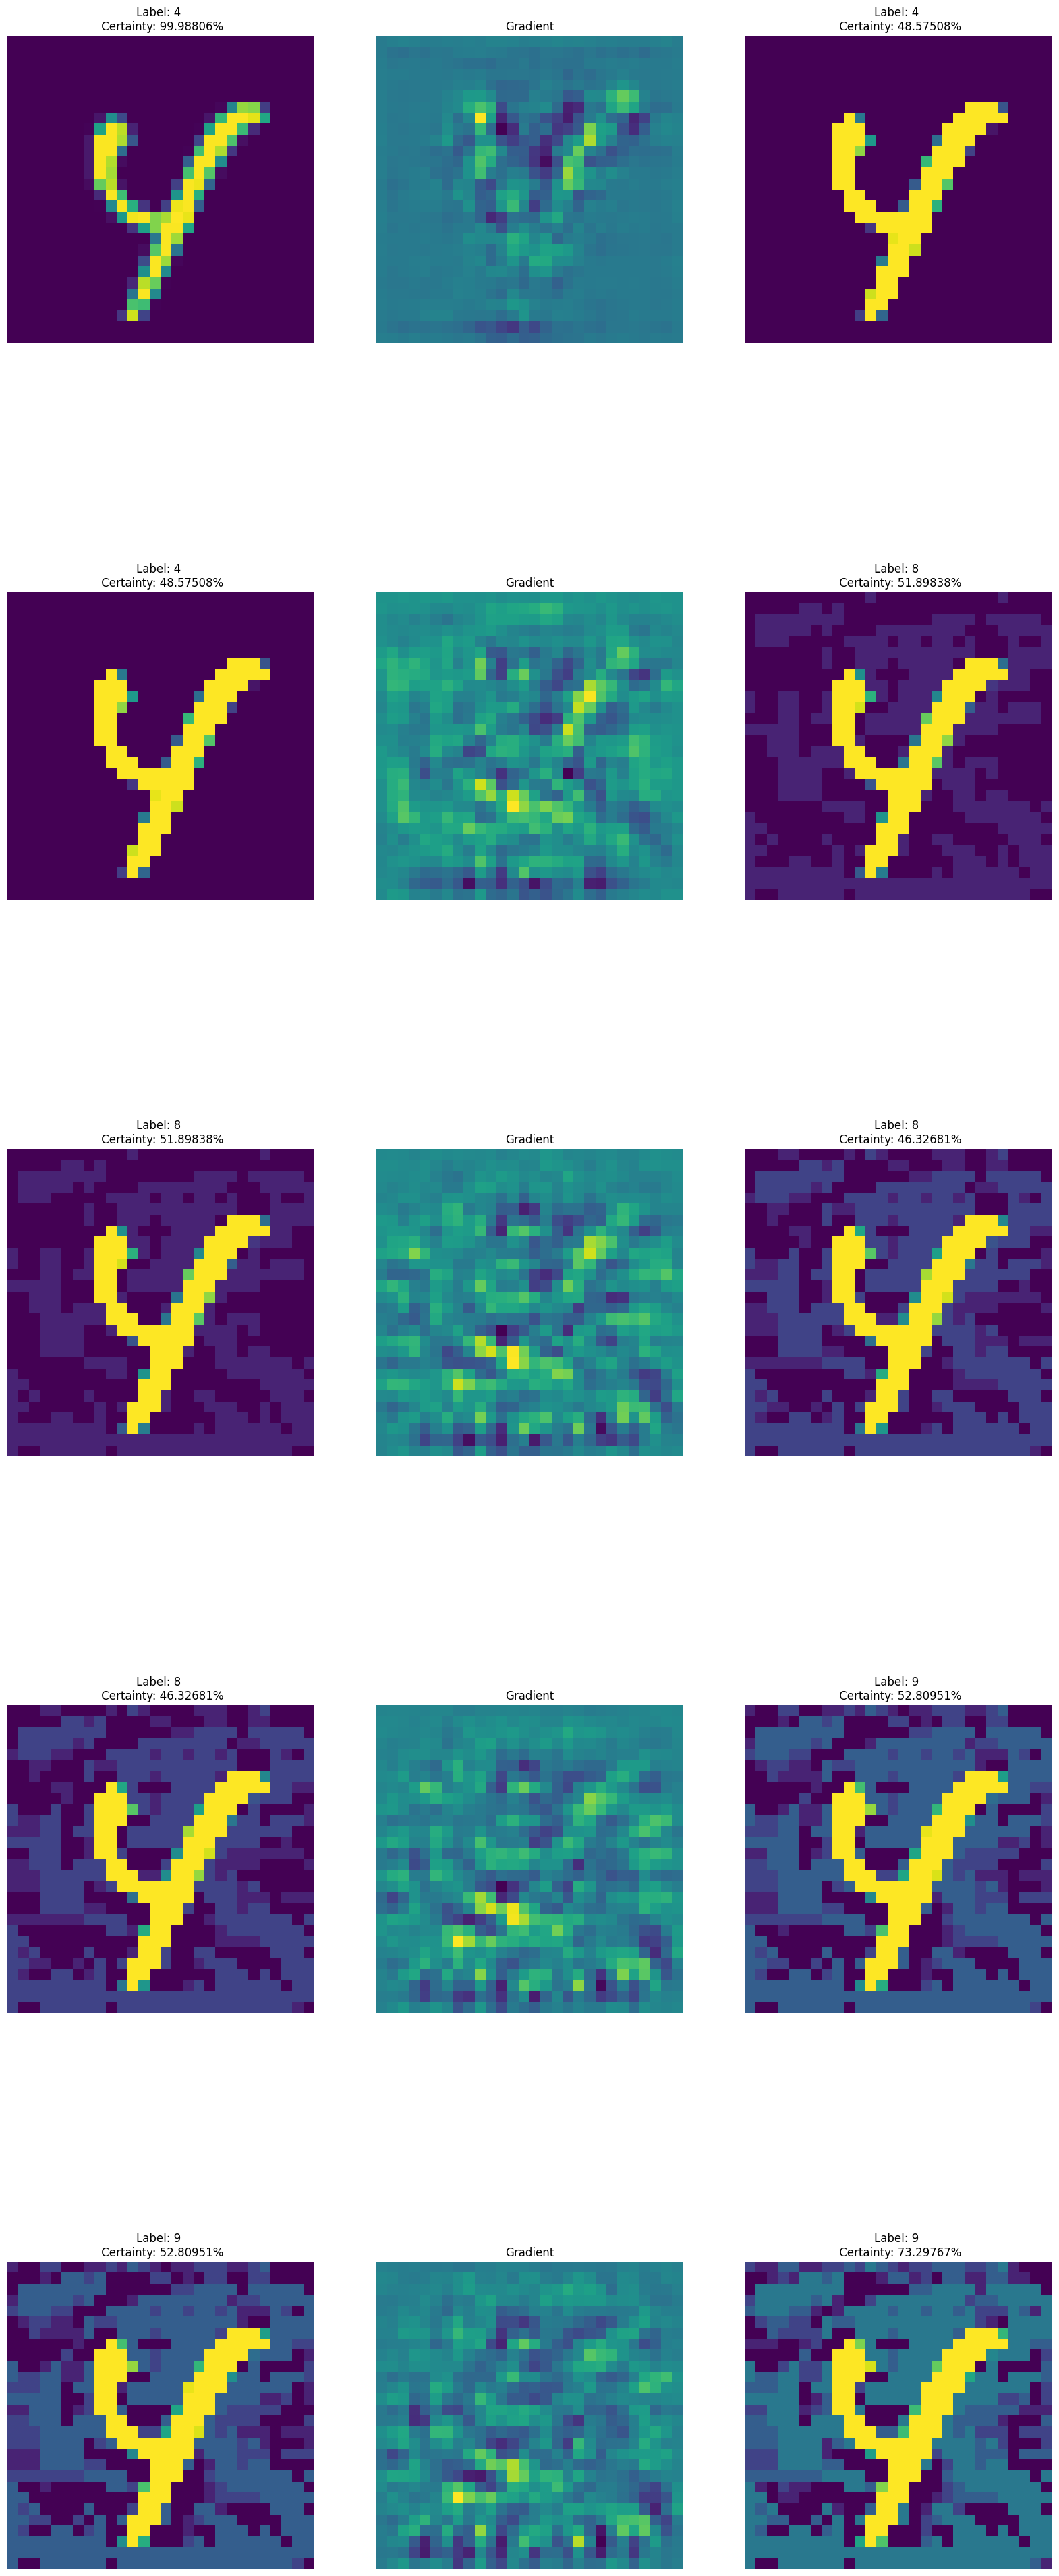

In [21]:
NR_RUNS = 5
random_four = fours[random.randint(0,len(fours)-1)]
fig, axes = plt.subplots(NR_RUNS,3, figsize=(20,10*NR_RUNS))
plt.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axes):
    random_four.requires_grad_(True)
    output = model(random_four.unsqueeze(0).to(device))
    loss = criterion(output,torch.tensor(9).unsqueeze(0).to(device))
    loss.backward()
    gradients = random_four.grad
    
    _ = random_four.requires_grad_(False)

    probs = F.softmax(output,dim=1).squeeze().tolist()
    label = torch.argmax(output).item()

    #Subtract directional gradient to four
    adv_four = random_four - torch.sign(gradients-random_four)*0.1
    adv_four = torch.clip(adv_four, min=0, max=1)
    
    
    new_output = model(adv_four.to(device).unsqueeze(0))

    
    new_probs = F.softmax(new_output,dim=1).squeeze().tolist()
    new_label = torch.argmax(new_output).item()
    
    
    
    ax[0].set_title(f"Label: {label} \n Certainty: {round(probs[label]*100,5)}%")
    ax[1].set_title(f"Gradient")
    ax[2].set_title(f"Label: {new_label} \n Certainty: {round(new_probs[new_label]*100,5)}%")
    ax[0].axis("off")
    ax[1].axis("off")
    ax[2].axis("off")
    
    ax[0].imshow(random_four.squeeze())
    ax[1].imshow(gradients.squeeze())
    ax[2].imshow(adv_four.squeeze())
    random_four = adv_four




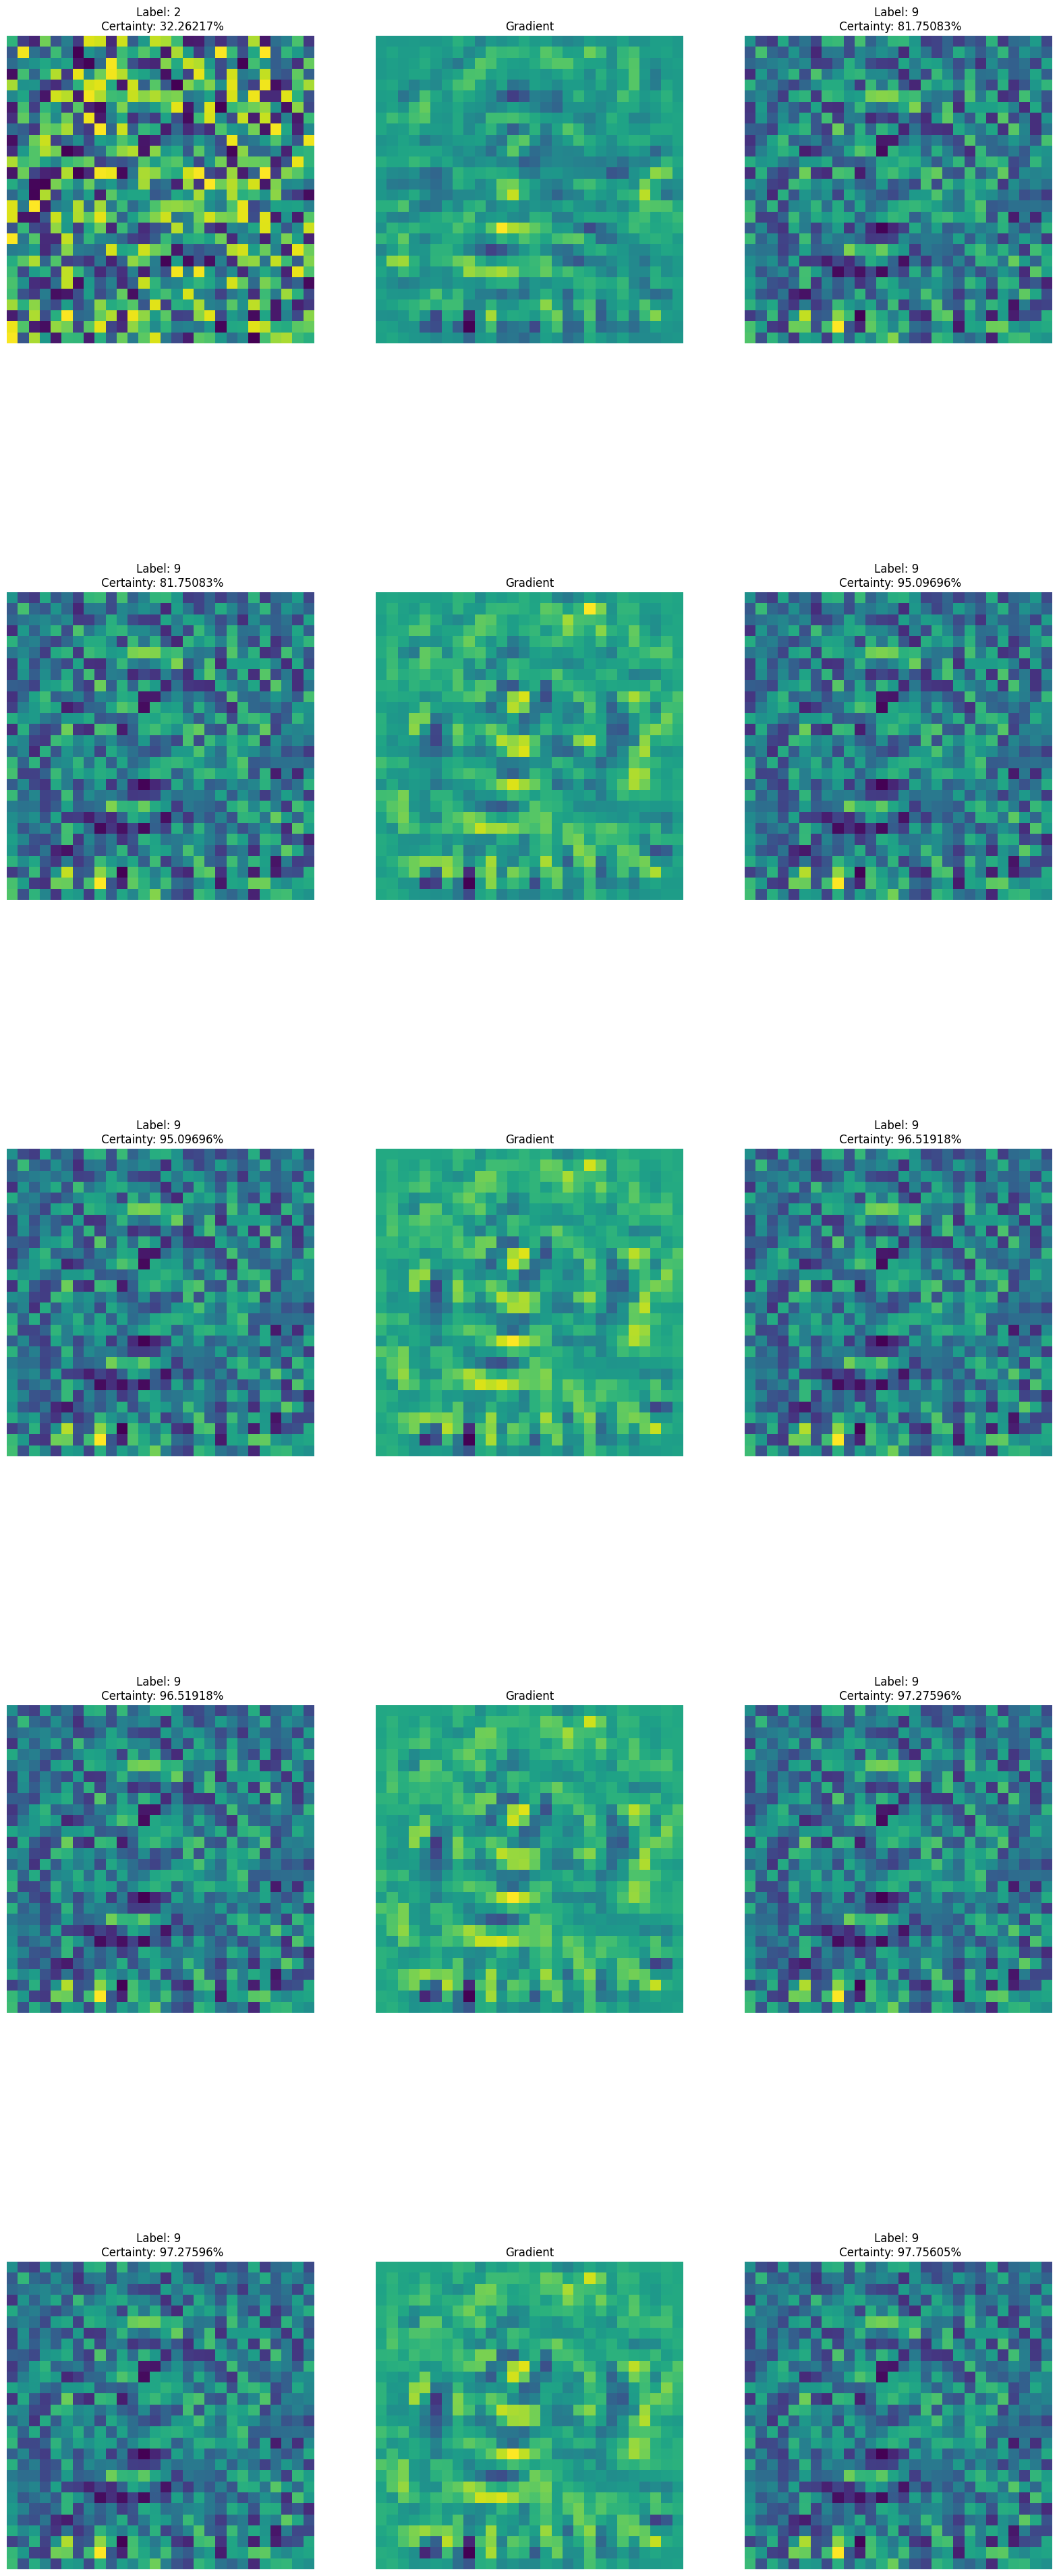

In [10]:
NR_RUNS = 5
random_noise = torch.rand(1,28,28)
fig, axes = plt.subplots(NR_RUNS,3, figsize=(20,10*NR_RUNS))
plt.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axes):
    random_noise.requires_grad_(True)
    output = model(random_noise.unsqueeze(0).to(device))
    loss = criterion(output,torch.tensor(9).unsqueeze(0).to(device))
    loss.backward()
    gradients = random_noise.grad
    
    _ = random_noise.requires_grad_(False)
    gradients = gradients

    probs = F.softmax(output,dim=1).squeeze().tolist()
    label = torch.argmax(output).item()

    #Subtract directional gradient to four
    adv_noise = random_noise - (gradients)
    
    
    new_output = model(adv_noise.to(device).unsqueeze(0))

    
    new_probs = F.softmax(new_output,dim=1).squeeze().tolist()
    new_label = torch.argmax(new_output).item()
    
    
    
    ax[0].set_title(f"Label: {label} \n Certainty: {round(probs[label]*100,5)}%")
    ax[1].set_title(f"Gradient")
    ax[2].set_title(f"Label: {new_label} \n Certainty: {round(new_probs[new_label]*100,5)}%")
    ax[0].axis("off")
    ax[1].axis("off")
    ax[2].axis("off")
    
    ax[0].imshow(random_noise.squeeze())
    ax[1].imshow(gradients.squeeze())
    ax[2].imshow(adv_noise.squeeze())
    random_noise = adv_noise


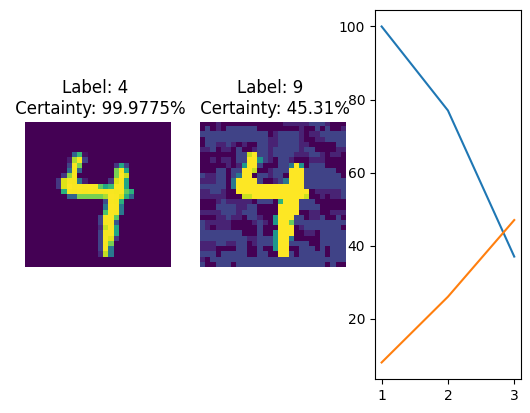

In [20]:



def create_adv(orig_img,orig_label, target_label, lr, epsilon):
    orig_probs = []
    adv_probs = []
    runs = 0
    while True:
        orig_img.requires_grad_(True)
        output = model(orig_img.unsqueeze(0).to(device))
        loss = criterion(output,torch.tensor(target_label).unsqueeze(0).to(device))
        loss.backward()
        gradients = orig_img.grad
        
        _ = orig_img.requires_grad_(False)
        gradients = gradients * lr
    
        probs = F.softmax(output,dim=1).squeeze().tolist()
        label = torch.argmax(output).item()
        orig_probs.append(round(probs[orig_label]*100))
        adv_img = orig_img - torch.sign(gradients-orig_img)*lr
        eta = torch.clip(adv_img-orig_img, min=-epsilon, max=epsilon)
        adv_img = torch.clip(orig_img+eta,0,1)
        
        
        new_output = model(adv_img.to(device).unsqueeze(0))
    
        
        new_probs = F.softmax(new_output,dim=1).squeeze().tolist()
        new_label = torch.argmax(new_output).item()
        adv_probs.append(round(new_probs[target_label]*100))
        
        
        
        runs += 1
        orig_img = adv_img
        if new_label == target_label:
            return adv_img, orig_probs, adv_probs, runs
    
    


random_four = fours[random.randint(0,len(fours)-1)]
orig_img = random_four
output = model(orig_img.unsqueeze(0).to(device))
probs = F.softmax(output,dim=1).squeeze().tolist()
lr = 0.1
epsilon = 0.3
orig_label = 4
target_label = 9
adv_img, orig_probs, adv_probs, runs = create_adv(orig_img,orig_label,target_label,lr,epsilon)

fig, axes = plt.subplots(1,3)
axes[0].set_title(f"Label: {orig_label} \n Certainty: {round(probs[orig_label]*100,4)}%")
axes[0].axis("off")
axes[0].imshow(random_four.squeeze())

axes[1].set_title(f"Label: {target_label} \n Certainty: {round(new_probs[new_label]*100,4)}%")
axes[1].axis("off")
axes[1].imshow(adv_img.squeeze())

run_list = []
for i in range(runs):
    run_list.append(i+1)
axes[2].plot(run_list,orig_probs)
axes[2].plot(run_list,adv_probs)

